In [1]:
import os
import sys
import cv2
import torch

import numpy as np
import albumentations as album
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from torchmetrics import JaccardIndex

sys.path.insert(0, '..')
from loaders.datasets import AmsterdamDataset
from utils.general import visualize
from utils.augmentation import *
from utils.metrics import BlobOverlap

In [2]:
# preprocessing_fn = smp.encoders.get_preprocessing_fn('efficientnet-b3', 'imagenet')
model = torch.load(os.path.join('..', 'experiments', 'fences', 'resnet18-unet-1600s-aug', 'best_model.pth'))

images = os.path.join('..', 'data', 'images')
annotations = os.path.join('..', 'data', 'fences-quays', 'annotations', 'test-annotations-11px.json')

data = AmsterdamDataset(images, annotations, preprocessing=get_preprocessing(None), train=False)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


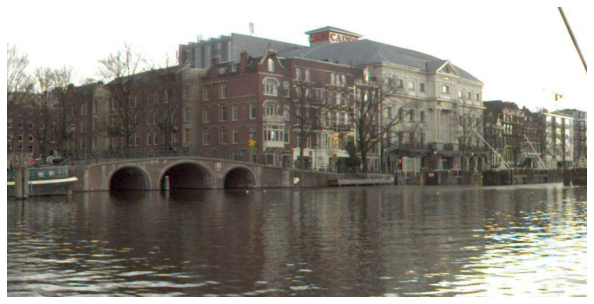

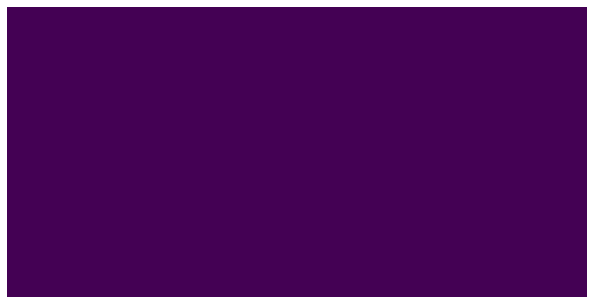

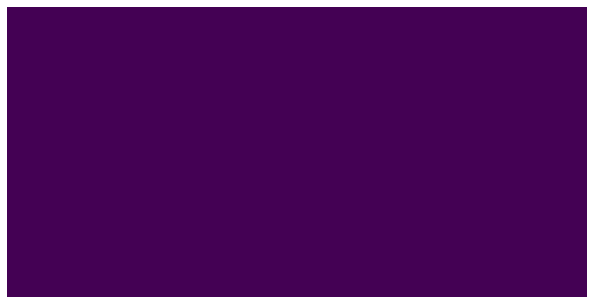

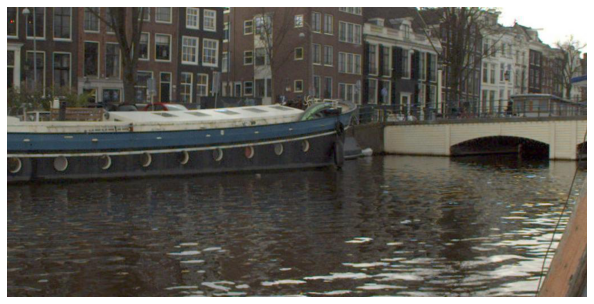

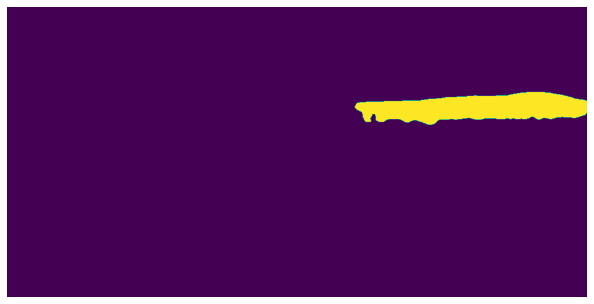

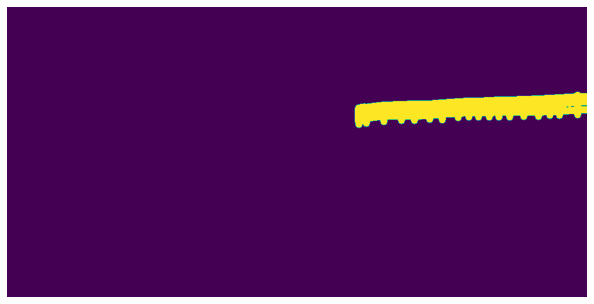

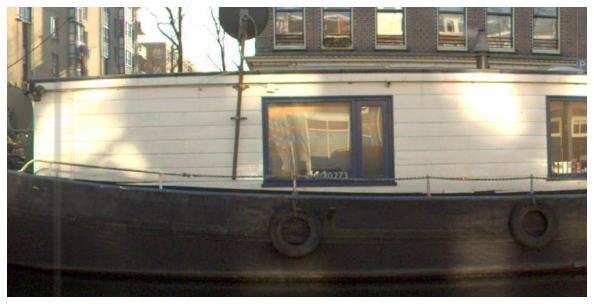

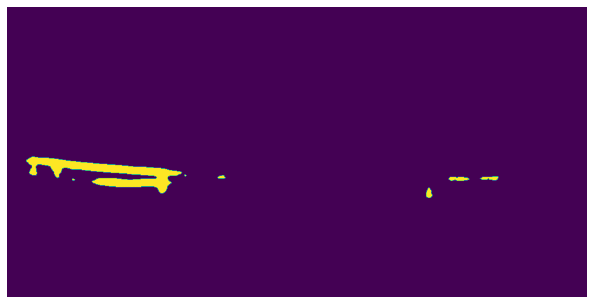

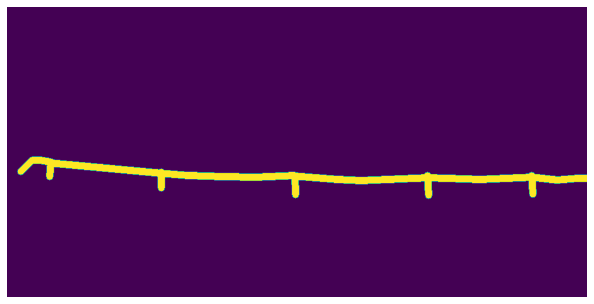

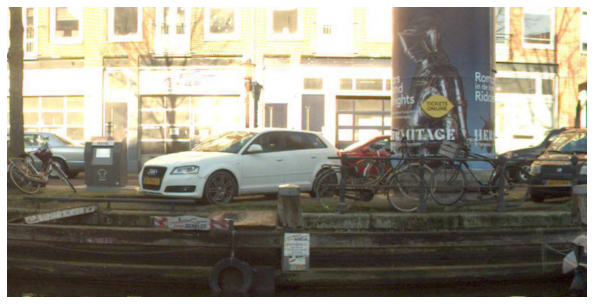

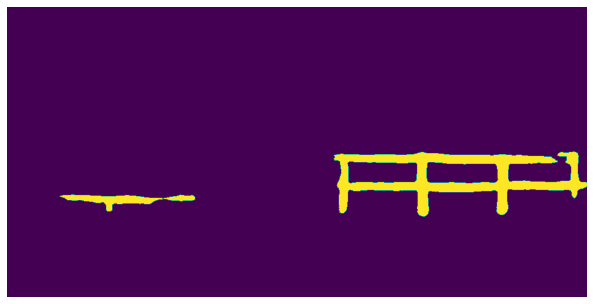

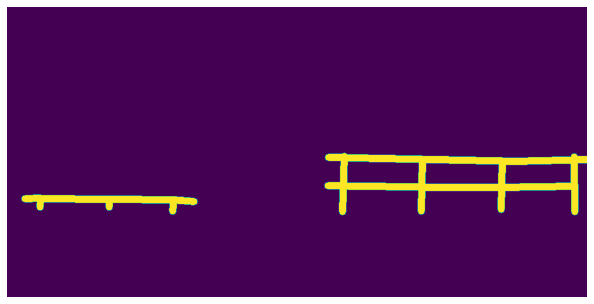

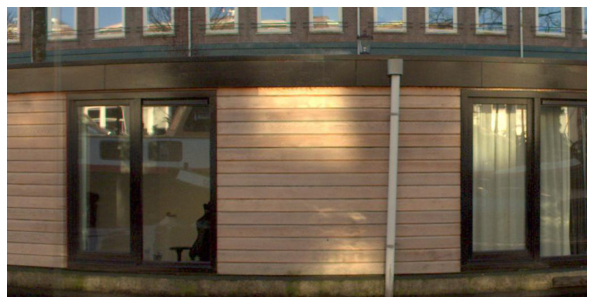

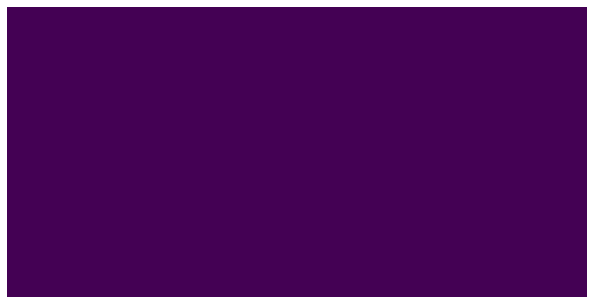

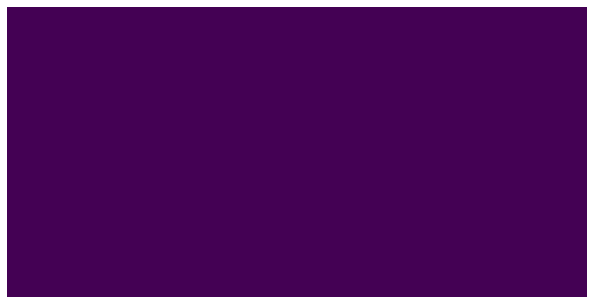

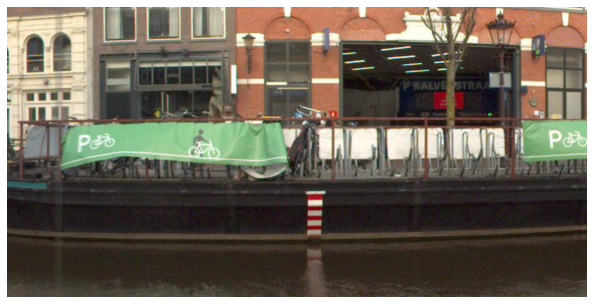

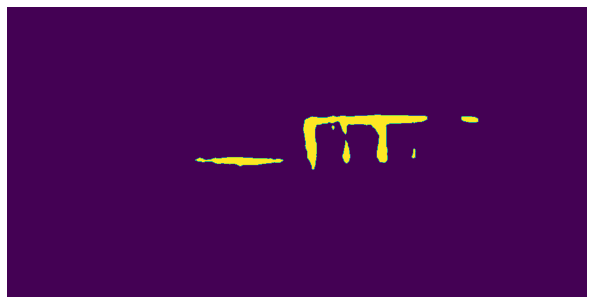

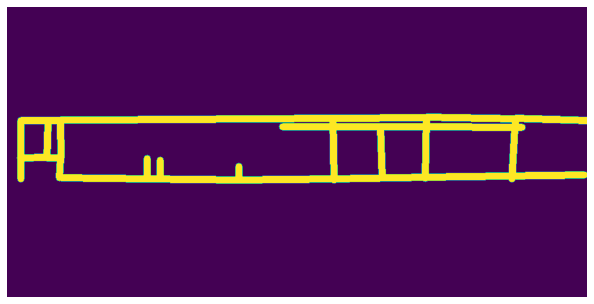

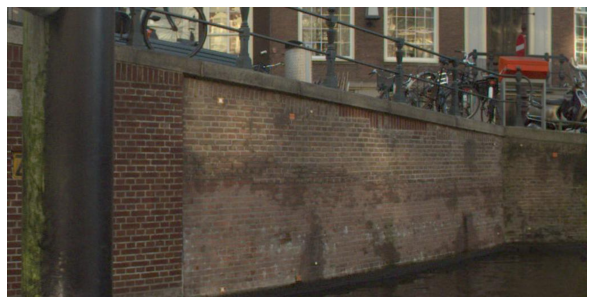

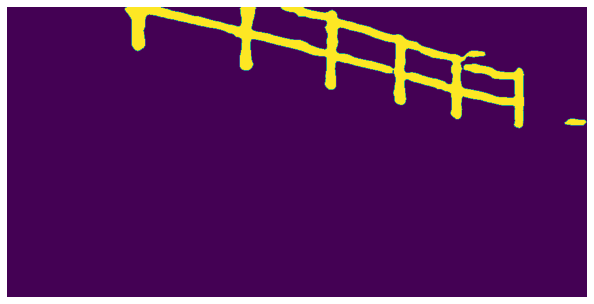

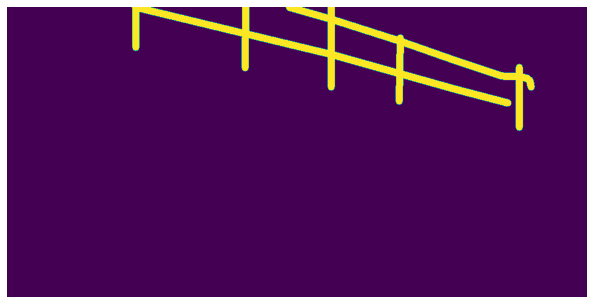

KeyboardInterrupt: 

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (1024/96, 512/96)

pxs = [i for i in range(3, 20)] + [i for i in range(20, 60, 10)]

mious = []
mbious = []


for i, (image, mask) in enumerate(data):
    img = plt.imread(os.path.join(images, data.images[i]['file_name']))

    mask = np.squeeze(mask)
    x = torch.as_tensor(image).unsqueeze(0).cuda()

    with torch.no_grad():
        pred = model(x)

    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    plt.imshow((pred > .5).squeeze().cpu())
    plt.axis('off')
    plt.show()
    
    plt.imshow(mask)
    plt.axis('off')
    plt.show()

mious.append(miou / (i + 1))
BO.update(preds, targets)
mbious.append(BO.compute())

In [ ]:
mious = [miou for miou in mious]

import pandas as pd

df = pd.DataFrame({'px':pxs, 'positive_iou':mious, 'blob_iou':mbious})

df.to_csv('test-pxs-results.csv', index=False)

In [ ]:
prediction = pred.squeeze().cpu().numpy() > .5
target = mask.copy()

target[np.where(target == 0)] = -1
diff = target - prediction

# 0 = TP / TN
# -1 = FP
# 1 = FN
print('TP:', np.count_nonzero(diff == 0))
print('TN:', np.count_nonzero(diff == -1))
print('FP:', np.count_nonzero(diff == -2))
print('FN:', np.count_nonzero(diff == 1))



print(np.unique(diff))

visualize(difference=diff)

In [ ]:
from utils.metrics import PositiveConfusionMatrix

pcm = PositiveConfusionMatrix()

print(pcm(pred.squeeze().cpu(), torch.as_tensor(mask)))

In [ ]:
from torchmetrics import ConfusionMatrix

cm = ConfusionMatrix(num_classes=2, normalize='true')

print(np.unique(mask))
mask[mask == -1] = 0

print(cm(pred.squeeze().cpu(), torch.as_tensor(mask).int()))

In [ ]:
# TN FP
# FN TP